# 1. Regresión

Revisaremos los conceptos de regresión vistos en el teórico.

Haremos pruebas con datos de entrada de **una dimensión**.

In [64]:
import numpy as np
import matplotlib.pyplot as plt

In [66]:
import numpy as np
np.set_printoptions(suppress=True)  # no usar notacion "e"

## Función Verdadera Oculta

Usaremos como función oculta un sinusoide.

In [89]:
def create_sinusoidal_data(spread=0.25, data_size=50):
    np.random.seed(0)
    x = np.linspace(0, 1, data_size)
    y = np.sin(2 * np.pi * x) + np.random.normal(scale=spread, size=x.shape)

    return x, y

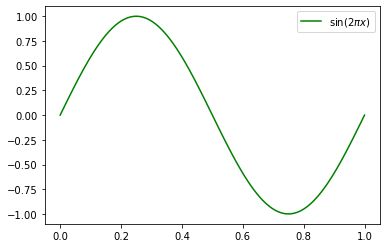

In [83]:
x, f_x = create_sinusoidal_data(0, 100)
plt.plot(x, f_x, color="green", label="$\sin(2\pi x)$")
plt.legend()
plt.show()

## Muestra Ruidosa

Tomaremos puntos uniformes en $x$, ruidosos en $y$.

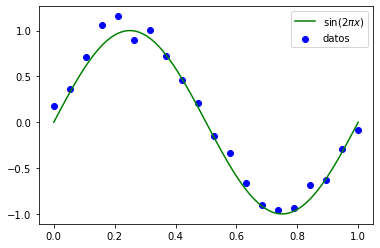

In [6]:
data_size = 20
X, y = create_sinusoidal_data(0.10, data_size)

plt.scatter(X, y, color="blue", label="datos")
plt.plot(x, f_x, color="green", label="$\sin(2\pi x)$")
plt.legend()
plt.show()

## División en Entrenamiento y Evaluación

Dividiremos aleatoriamente los datos en una parte para entrenamiento y otra para evaluación.

Usaremos 
[train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) de scikit-learn:

In [127]:
from sklearn.model_selection import train_test_split

train_size = 15
test_size = data_size - train_size
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=0)

In [128]:
X_train.shape, X_test.shape

((15,), (5,))

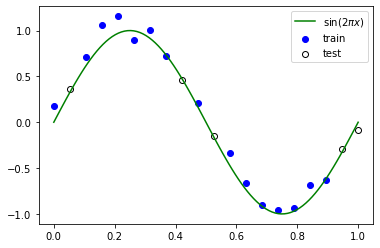

In [129]:
plt.scatter(X_train, y_train, color="blue", label="train")
plt.scatter(X_test, y_test, color="white", edgecolor="k", label="test")
plt.plot(x, f_x, color="green", label="$\sin(2\pi x)$")
plt.legend()
plt.show()

## Regresión Lineal

Probaremos ajustar los puntos usando una recta.

Vamos a programar a mano el aprendizaje y la predicción.

### Solución de Cuadrados Mínimos

Datos de entrenamiento:
- $X \in R^{N \times K}:$ $N$ vectores de entrada, de $K$ dimensiones cada uno.
- $y \in R^N:$ $N$ valores de salida.

Aprendizaje:

$$w^* = (X^\top X)^{-1} X^\top y$$

Predicción:

$$f_{w^*}(x) = x^\top w^* = \sum_{k=1}^K x_k w^*_k$$

Con $K=1$ tendríamos:

$$f_{w^*}(x) = x_1 w_1^*$$

Para que sea una recta nos falta un $w_0$ ("bias").
Esto se puede resolver haciendo $K=2$ y agregando un valor constante 1 a cada dato:

$$f_{w^*}((1, x)) = w_0 + x_1 w_1^*$$


In [99]:
X_train

array([0.57894737, 0.15789474, 0.        , 0.78947368, 0.63157895])

In [101]:
X_train_bias = np.stack((np.ones(X_train.shape[0]),X_train), axis=1)  # add bias
X_train_bias

array([[1.        , 0.57894737],
       [1.        , 0.15789474],
       [1.        , 0.        ],
       [1.        , 0.78947368],
       [1.        , 0.63157895]])

In [102]:
def linear_least_squares(X, y):
    X_b = np.stack((X, np.ones(X.shape[0])), axis=1)  # add bias
    return np.linalg.pinv(X_b.T.dot(X_b)).dot(X_b.T.dot(y))

def f(X, w):
    X_b = np.stack((X, np.ones(X.shape[0])), axis=1)  # add bias: (1, x)
    return X_b.dot(w)

### Entrenar

In [103]:
X_train, y_train

(array([0.57894737, 0.15789474, 0.        , 0.78947368, 0.63157895]),
 array([-0.33052004,  1.0612558 ,  0.17640523, -0.93603283, -0.65962014]))

In [104]:
w = linear_least_squares(X_train, y_train)

In [23]:
w

array([-1.95626346,  0.70657973])

### Graficar

Graficaremos la función aprendida a partir de los datos de entrenamiento. También graficaremos con los datos de evaluación y la función oculta, para comparar.

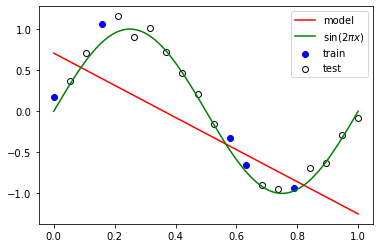

In [24]:
plt.scatter(X_train, y_train, color="blue", label="train")
plt.scatter(X_test, y_test, color="white", edgecolor="k", label="test")
plt.plot(x, f(x, w), color="red", label="model")
plt.plot(x, f_x, color="green", label="$\sin(2\pi x)$")
plt.legend()
plt.show()

### Predecir y Evaluar: Error Cuadrático Medio

Obtendremos los valores predichos para los datos de entrenamiento y de evaluación.
Calcularemos el error cuadrático medio sobre ambos conjuntos de datos.

In [105]:
y_train_pred = f(X_train, w)
y_test_pred = f(X_test, w)

Usamos la función [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) de scikit-learn:

In [106]:
from sklearn.metrics import mean_squared_error

train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)
print(f'Train error: {train_error:f}')
print(f'Test error: {test_error:f}')

Train error: 0.151445
Test error: 0.381363


## Regresión Polinomial

Ahora haremos regresión polinomial. En este caso usaremos scikit-learn para definir el modelo, entrenar y predecir.

En scikit-learn cada dato de entrada debe ser un vector, no un número. Debemos convertir cada dato en un vector de una dimensión:

In [130]:
X_train.shape, X_test.shape

((15,), (5,))

In [131]:
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
X_train.shape, X_test.shape

((15, 1), (5, 1))

### Features Polinomiales

En scikit-learn, la regresión polinomial se implementa como un modelo de dos pasos.

El primer paso genera vectores de características polinomiales, y el segundo paso aplica una regresión lineal sobre estos vectores (ver [Polynomial interpolation](https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html)).

Por ejemplo, para generar características polinomiales de grado 5:

In [110]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(5)  # polinomio de grado 5
pf.fit(X_train)             # no necesita y_train!

PolynomialFeatures(degree=5)

In [111]:
X_train2 = pf.transform(X_train)

In [112]:
X_train2.shape

(5, 6)

In [113]:
X_train2

array([[1.        , 0.57894737, 0.33518006, 0.19405161, 0.11234567,
        0.06504223],
       [1.        , 0.15789474, 0.02493075, 0.00393643, 0.00062154,
        0.00009814],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [1.        , 0.78947368, 0.6232687 , 0.49205424, 0.38846387,
        0.306682  ],
       [1.        , 0.63157895, 0.39889197, 0.25193177, 0.1591148 ,
        0.10049356]])

### Instanciar y Entrenar

Crearemos y entrenaremos un modelo de grado 2.

Como siempre en scikit-learn, para entrenar usamos la función **fit**.

In [132]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

degree = 2
pf = PolynomialFeatures(degree)
lr = LinearRegression(fit_intercept=False)  # el bias ya esta como feature
model = make_pipeline(pf, lr)

In [133]:
model.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression(fit_intercept=False))])

In [ ]:
#equivalente - comentario de clase
Z_train=pf.fit(X_train)
lr.fit(Z_train, y_train)

### Inspeccionar Parámetros

Ver [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

In [116]:
lr.coef_

array([ 0.45340784,  1.62753594, -4.67896686])

In [122]:
lr.intercept_

0.0

### Graficar Resultado

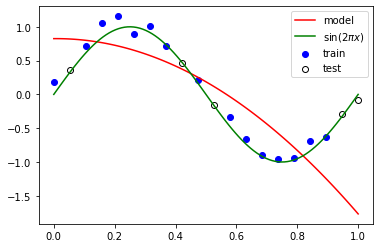

In [134]:
plt.scatter(X_train, y_train, color="blue", label="train")
plt.scatter(X_test, y_test, color="white", edgecolor="k", label="test")
plt.plot(x, model.predict(x.reshape(-1, 1)), color="red", label="model") #aca llamo a predict
plt.plot(x, f_x, color="green", label="$\sin(2\pi x)$")
plt.legend()
plt.show()

### Predecir y Evaluar

Para predecir, usamos la función **predict**:

In [40]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [41]:
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)
print(f'Train error: {train_error:0.2}')
print(f'Test error: {test_error:0.2}')

Train error: 0.091
Test error: 0.87


## Sobreajuste vs. Generalización

Probaremos polinomios de varios grados, obteniendo valores de error en entrenamiento y evaluación:

In [145]:
train_errors = []
test_errors = []
degrees = [0, 1, 2, 3, 4, 5, 6]
for degree in degrees:
    # train:
    pf = PolynomialFeatures(degree)
    lr = LinearRegression(fit_intercept=False)
    model = make_pipeline(pf, lr)
    model.fit(X_train, y_train)
    
    # predict:
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # evaluate:
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)
    train_errors.append(train_error)
    test_errors.append(test_error)
    print(f'Grado {degree}')
    print(f'Coeficientes {lr.coef_}')
    print(f'Train Error:{train_error}')
    print(f'Test Error:{test_error}')
    

Grado 0
Coeficientes [0.0558214]
Train Error:0.6243432033240723
Test Error:0.08953844966501734
Grado 1
Coeficientes [ 1.18074012 -2.39255101]
Train Error:0.17725226545572784
Test Error:0.4927263548696522
Grado 2
Coeficientes [ 0.82490143  0.0387866  -2.63167844]
Train Error:0.1489298320403855
Test Error:0.9147956013258186
Grado 3
Coeficientes [  0.09504708  10.64572916 -32.78620921  22.38524311]
Train Error:0.007466992886673655
Test Error:0.04609361995665768
Grado 4
Coeficientes [  0.14172286   9.02163083 -23.70250308   6.16831391   9.0521168 ]
Train Error:0.006347019896489194
Test Error:0.13757947268869336
Grado 5
Coeficientes [  0.171214     6.45943365  -0.53540461 -66.25818381 101.52222894
 -41.35618765]
Train Error:0.005123747528770479
Test Error:0.005690754235972923
Grado 6
Coeficientes [   0.16401594    8.47136625  -26.97936081   57.43800525 -160.01630309
  214.21690858  -93.8978196 ]
Train Error:0.004871718054160688
Test Error:0.06897838716174168


Graficaremos las curvas de error en términos del grado del polinomio.

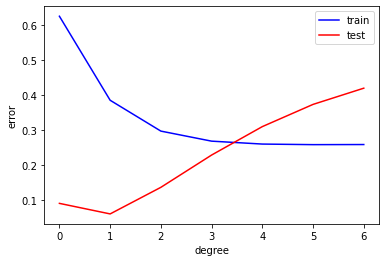

In [160]:
plt.plot(degrees, train_errors, color="blue", label="train")
plt.plot(degrees, test_errors, color="red", label="test")
plt.legend()
plt.xlabel("degree")
plt.ylabel("error")
plt.show()

Se puede ver que el error en entrenamiento siempre baja, pero que en algún punto comienza el sobreajuste, ya que el error en evaluación empieza a subir.

### Mejor Modelo

De acuerdo a la gráfica anterior, y como era de esperarse, el modelo que mejor ajusta los datos es el de grado 3:

In [144]:
degree = 5
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X_train, y_train);

Graficamos:

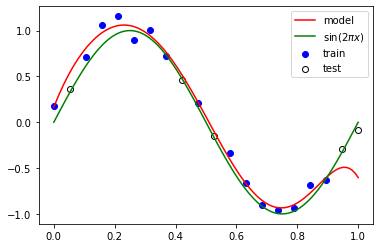

In [143]:
plt.scatter(X_train, y_train, color="blue", label="train")
plt.scatter(X_test, y_test, color="white", edgecolor="k", label="test")
plt.plot(x, model.predict(x.reshape(-1, 1)), color="red", label="model")
plt.plot(x, f_x, color="green", label="$\sin(2\pi x)$")
plt.legend()
plt.show()

### Modelo Sobreajustado

Veamos cómo es la gráfica de uno de los modelos que sufre de sobreajuste:

In [54]:
degree = 8
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X_train, y_train);

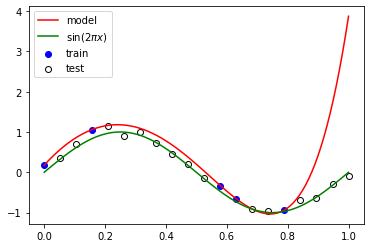

In [55]:
plt.scatter(X_train, y_train, color="blue", label="train")
plt.scatter(X_test, y_test, color="white", edgecolor="k", label="test")
plt.plot(x, model.predict(x.reshape(-1, 1)), color="red", label="model")
plt.plot(x, f_x, color="green", label="$\sin(2\pi x)$")
plt.legend()
plt.show()

## Ejercicios

1. Probar agregando puntos a los datos de entrenamiento para prevenir el sobreajuste en polinomios de grado alto.
2. Imprimir los parámetros de los modelos para cada grado.
3. Probar usando regularización para prevenir el sobreajuste en polinomios de grado alto
(ver [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)).
4. Hicimos todo con datos de entrada de una dimensión. ¿Cómo serían los features polinomiales en datos de 2 o más dimensiones?

In [159]:
#regularización de polinomios
from sklearn.linear_model import Ridge
train_errors = []
test_errors = []
degrees = [0, 1, 2, 3, 4, 5, 6]
for degree in degrees:
    # train:
    pf = PolynomialFeatures(degree)
    lr = Ridge(fit_intercept=False,alpha=2.0)
    model = make_pipeline(pf, lr)
    model.fit(X_train, y_train)
    
    # predict:
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # evaluate:
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)
    train_errors.append(train_error)
    test_errors.append(test_error)
    print(f'Grado {degree}')
    print(f'Coeficientes {lr.coef_}')
    print(f'Train Error:{train_error}')
    print(f'Test Error:{test_error}')


Grado 0
Coeficientes [0.04925418]
Train Error:0.6243863317483527
Test Error:0.08964000324518243
Grado 1
Coeficientes [ 0.37035232 -0.77399031]
Train Error:0.38430283947632427
Test Error:0.059504258454075844
Grado 2
Coeficientes [ 0.43808269 -0.54181925 -0.6214622 ]
Train Error:0.2961496420418916
Test Error:0.1355024073374011
Grado 3
Coeficientes [ 0.45393772 -0.44871738 -0.52290382 -0.42866647]
Train Error:0.26744867978294296
Test Error:0.22773093429314697
Grado 4
Coeficientes [ 0.45756392 -0.40879052 -0.47735139 -0.3851133  -0.28566177]
Train Error:0.25910913259268276
Test Error:0.3089993101403388
Grado 5
Coeficientes [ 0.45808829 -0.3908452  -0.45548948 -0.36337586 -0.26539923 -0.18788062]
Train Error:0.2574623423596392
Test Error:0.3724810540912288
Grado 6
Coeficientes [ 0.45789037 -0.3825479  -0.44476023 -0.35233345 -0.25485566 -0.1781463
 -0.12216211]
Train Error:0.25776674097115726
Test Error:0.4187946774122734


## Referencias

Scikit-learn:

- [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
- [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)
- [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)
- [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
